# Lesson 8 | Convolutions & CNNs
> Convolutions, Pools, BatchNorm

> Checkout this notebook in [colab](https://colab.research.google.com/github/nglillywhite/blog/blob/main/posts/2023-03-08%20Fastai%20Lesson%208.ipynb)

## Book Content

This week, the lecture is mostly insane excels that show the same convolutions and filters that we work through in the book so there isn't 2 large sets of content to work through, I'll stick with just the book content. I highly recommend you checkout [the lecture](https://www.youtube.com/watch?v=htiNBPxcXgo) to see that absolute insanity that Jeremy is able to do in excel.

### Convolutional Neural Nets | CNNs

### What is a Convolution

A convolution is a the result of a *kernel* applied over an image/tensor/input. A kernel is a small matrix that acts like a sliding window over the inputs, the sum of the dot product of the kernel window on the tensor is then stored in the resulting tensor.

### Kernels

The kernel will have a few attributes, one is the size/shape of the windor, we're going to use a 3x3 matrix in this example, and a stride, which is by how many elements the window jumps between calculating the dot product. This will start to make more sense with some working examples but the important thing to know is the 'sliding window' effect and that you sum the dot product of the window on your input tensor.

Lets do a small example

In [ ]:
from fastai.vision.all import *

window = tensor([[-1,-1,-1],
                 [0 , 0, 0],
                 [1 , 1, 1]])

y = torch.randn(4,4)

The first kernel result would be the first 3x3 grid of the y tensor multiplied and summed as the first result. Our 'window' tensor will act as a kernel that we slide over our y tensor.

In [ ]:
y

tensor([[ 0.2001,  1.5715, -1.5885,  0.4756],
        [ 0.8621,  0.4825, -1.4162, -1.0264],
        [ 1.8944,  0.0826, -0.1479,  0.5534],
        [-0.7737, -1.1444,  0.8137,  0.0491]])

In [ ]:
y[0:3,0:3]

tensor([[ 0.2001,  1.5715, -1.5885],
        [ 0.8621,  0.4825, -1.4162],
        [ 1.8944,  0.0826, -0.1479]])

In [ ]:
window

tensor([[-1, -1, -1],
        [ 0,  0,  0],
        [ 1,  1,  1]])

In [ ]:
result = y[0:3,0:3] * window

result, result.sum()

(tensor([[-0.2001, -1.5715,  1.5885],
         [ 0.0000,  0.0000, -0.0000],
         [ 1.8944,  0.0826, -0.1479]]),
 tensor(1.6461))

above is the result of our first kernel convolution and we would store this in the \[0,0\] location of our result tensor and slide the window across by the stride length (lets use 1 in this example) and run the calculation again, to be stored in the \[0,1\] location of our final tensor.

In [ ]:
y[0:3,1:4]

tensor([[ 1.5715, -1.5885,  0.4756],
        [ 0.4825, -1.4162, -1.0264],
        [ 0.0826, -0.1479,  0.5534]])

In [ ]:
result = y[0:3,1:4] * window
result, result.sum()

(tensor([[-1.5715,  1.5885, -0.4756],
         [ 0.0000, -0.0000, -0.0000],
         [ 0.0826, -0.1479,  0.5534]]),
 tensor(0.0295))

This is a random example however, lets move onto MNIST images which we covered in an earlier lesson without convolutions but our fastai implementation did implement under the hood, which we can now replicate.

<AxesSubplot: >

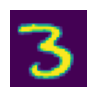

In [ ]:
path = untar_data(URLs.MNIST_SAMPLE)

im3 = Image.open(path/'train/3/12.png')
show_image(im3)

So in order to run our kernel over the top of our image, we'd start with the top left and work our way striding over and down the image respectively, lets checkout what that first kernel result would look like

In [ ]:
im3_t = tensor(im3)
im3_t[0:3,0:3]

tensor([[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]], dtype=torch.uint8)

Uh oh, our image is completely white in this top corner (0 being white, 255 being black). Lets look at a larger portion of our image and see if we can spot the top of this three

In [ ]:
df = pd.DataFrame(im3_t[4:10,2:20])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,12,99,91,142,155,246,182,155,155,155,155,131,52,0,0,0,0
2,0,138,254,254,254,254,254,254,254,254,254,254,254,252,210,122,33,0
3,0,220,254,254,254,235,189,189,189,189,150,189,205,254,254,254,75,0
4,0,35,74,35,35,25,0,0,0,0,0,0,13,224,254,254,153,0
5,0,0,0,0,0,0,0,0,0,0,0,0,90,254,254,247,53,0


Awesome, we've found the top chunk of the 3, lets now checkout the dot product and sum

In [ ]:
result = im3_t[4:7,6:9] * window

im3_t[4:7,6:9], result, result.sum()

(tensor([[  0,   0,   0],
         [142, 155, 246],
         [254, 254, 254]], dtype=torch.uint8),
 tensor([[  0,   0,   0],
         [  0,   0,   0],
         [254, 254, 254]]),
 tensor(762))

We can see that it zeroed out the middle row and then kept the lower row high valued which resulted in a high number when compared to an input tensor of zeroes or low values.

Lets make a small helper to allow us to apply the kernel over any range of elements more easily.

In [ ]:
def apply_kernel(row, col, kernel): return (im3_t[row-1:row+2,col-1:col+2] * kernel).sum()

In [ ]:
apply_kernel(5,7,window)

tensor(762)

Great, we can replicate our previous result as well. Lets apply our kernel over the entire image and see what we get back

<AxesSubplot: >

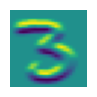

In [ ]:
space = range(1,27)

top = tensor([[apply_kernel(i,j,window) for j in space] for i in space])
show_image(top)

We can see the top horizontal edges (our -1,-1,-1 vector in our window kernel) are highlighted, whilst the bottom edges and vertical lines are dark and ignored respectively. Our window is a 'top edge' kernel/window

<AxesSubplot: >

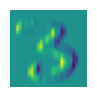

In [ ]:
left = tensor([[-1, 1, 0],
               [-1, 1, 0],
               [-1, 1, 0]]).float()

left_edge = tensor([[apply_kernel(i,j,left) for j in space] for i in space])
show_image(left_edge)

And the same logic is applied for the 'left' edge in the image, which have been highlighted. This [paper](https://arxiv.org/abs/1603.07285) has lots of awesome images to explain this better than I've written it (as well as the [fastai book](https://github.com/fastai/fastbook/blob/master/13_convolutions.ipynb) which mentions this particular paper.

### Pytorch Implementation

Being common calculations and widely used, pytorch has these types of functions built in within the `torch.nn.functional` library which we can simply call. The other awesome thing is that multiple kernels can be applied at the same time.

In [ ]:
diag1 = tensor([[ 0,-1,1],
                [-1, 1,0],
                [ 1, 0,0]])

diag2 = tensor([[1 ,-1,0],
                [0 , 1,0],
                [0 , 0,1]])

top = tensor([[1 ,-1,0],
              [0 , 1,0],
              [0 , 0,1]])

edge_kernels = torch.stack([left, top, diag1, diag2])
edge_kernels.shape

torch.Size([4, 3, 3])

The other fantastic thing is that pytorch will apply these kernels to multiple images at once, which means we can apply multiple kernels to multiple images in a single go. We can apply this to a whole mini-batch really easily, lets get a dataloader going.

In [ ]:
mnist = DataBlock(blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
                  get_items=get_image_files,
                  splitter=GrandparentSplitter(),
                  get_y=parent_label)

dls = mnist.dataloaders(path)
xb,yb = first(dls.valid)
xb.shape

torch.Size([64, 1, 28, 28])

fastai by default loads up the GPU with your tensors, lets move this to the CPU since our `conv2d` gets calculated there by defaults (all will be explained in the next paragraph)

In [ ]:
xb,yb = to_cpu(xb), to_cpu(yb)

The above shape is a batch of 64 images, with one channel of a 28x28 pixel grid, Pytorch represents images as a rank-3 tensor, being `[channels, rows, columns]`.

`F.conv2d` which is our pytorch module which will run our kernels for us requires a rank-4 tensor (`[channels_in, features_out, rows, columns]`). Our `edge_kernels` doesn't have this shape at the moment and we need to tell pytorch we've only got 1 channel since we don't have a multi-colour image with the red,green, blue channels that you'd expect. 

We're going to insert a 'unit axis' which is an axis of size 1 in the first location to match the `channels_in` attribute, we can do this with the `unsqueeze` method. Unsqueeze places a 'unit axis' in the position that you give it, in our case we want to place it in the first position.

In [ ]:
edge_kernels.shape, edge_kernels.unsqueeze(1).shape

(torch.Size([4, 3, 3]), torch.Size([4, 1, 3, 3]))

In [ ]:
torch.unsqueeze?

Docstring:
unsqueeze(input, dim) -> Tensor

Returns a new tensor with a dimension of size one inserted at the
specified position.

The returned tensor shares the same underlying data with this tensor.

A :attr:`dim` value within the range ``[-input.dim() - 1, input.dim() + 1)``
can be used. Negative :attr:`dim` will correspond to :meth:`unsqueeze`
applied at :attr:`dim` = ``dim + input.dim() + 1``.

Args:
    input (Tensor): the input tensor.
    dim (int): the index at which to insert the singleton dimension

Example::

    >>> x = torch.tensor([1, 2, 3, 4])
    >>> torch.unsqueeze(x, 0)
    tensor([[ 1,  2,  3,  4]])
    >>> torch.unsqueeze(x, 1)
    tensor([[ 1],
            [ 2],
            [ 3],
            [ 4]])
Type:      builtin_function_or_method


In [ ]:
edge_kernels.unsqueeze_(1)

tensor([[[[-1.,  1.,  0.],
          [-1.,  1.,  0.],
          [-1.,  1.,  0.]]],


        [[[ 1., -1.,  0.],
          [ 0.,  1.,  0.],
          [ 0.,  0.,  1.]]],


        [[[ 0., -1.,  1.],
          [-1.,  1.,  0.],
          [ 1.,  0.,  0.]]],


        [[[ 1., -1.,  0.],
          [ 0.,  1.,  0.],
          [ 0.,  0.,  1.]]]])

In [ ]:
batch_features = F.conv2d(xb, edge_kernels)
batch_features.shape

torch.Size([64, 4, 26, 26])

This shape is a 64 image mini-batch, 4 kernels, and the 26x26 image. We lose a pixel on either side of the 28 pixel image because we can't slide our 3x3 kernel all the way to the edge

### Padding

Now since we've lost two pixels on either side, what do we do? It's probably not a huge deal in this particular context but its still a signal loss that we'd like to not have. We can pad the image to be wider and taller than the original input so that we can not have this 'corner loss'.

I highly recommend you checkout the paper I mentioned earlier that is sourced from the fast.ai course as it has some wondeful visualisations of the problem & solution that we're covering here and its best not I re-hash great work in an inferior way.

Lets get back to networks.


### Creating a CNN

The book raises and interesting point that there's 'no reason to believe that some particular edge filters are the most useful kernels for image recognition.' I think its fascinating that the very 'human' intuition of looking for edges and static filter definitions like this is how we might solve the problem programatically but doesn't exactly fit the need for a neural net since they're different.

The book then emphasizes that we can 'learn' a good filter definition with SGD. I love that everytime there's something interesting in deep learning, don't bother trying to decide a good value, just start randomly and SGD!

The book also states a definition that "When we use convolutions instead of (or in addition to) regular linear layers, we create a convolutional neural network (CNN)."

Its helpful to come back to these definitions and to explicitly mention them at times, there's so much jargon and language in the ML space, its lovely to have nice and succint statments like this to rely on.



In [ ]:
net = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,1)
)
net

Sequential(
  (0): Linear(in_features=784, out_features=30, bias=True)
  (1): ReLU()
  (2): Linear(in_features=30, out_features=1, bias=True)
)

This is our simple linear model that we've made and reconstructed a few times before, lets now make a CNN with the nn modules.

In [ ]:
broken_cnn = nn.Sequential(
    nn.Conv2d(1,30, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(30,1, kernel_size=3, padding=1)
)
broken_cnn

Sequential(
  (0): Conv2d(1, 30, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(30, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [ ]:
broken_cnn(xb).shape

torch.Size([64, 1, 28, 28])

An interesting thing to note is that our conv2d layers don't need an input size since they're simply applied to the inputs regardless of shape as the window is slide over and down the input tensor whereas our linear layers need the correct input size to build weights for each pixel/input value.

Our broken_cnn output won't work since we spit out a set of 28\*28 activations from the kernel convolutions instead of a single output activation per image. One way to manage this is to use enough convolutions with stride-2 so that you continually shrink the image by half until you reach an activation size of 1.

We can try exactly this, first we will build a helper method to build each convolution for us.

In [ ]:
def conv(ni, nf, ks=3, act=True):
    res = nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, nn.ReLU())
    return res

simple_cnn = nn.Sequential(
    conv(1,4),             # 14x14
    conv(4,8),             # 7x7
    conv(8,16),            # 4x4
    conv(16,32),           # 2x2
    conv(32,2, act=False), #1x1
    Flatten()
)

In [ ]:
simple_cnn(xb).shape

torch.Size([64, 2])

Lets create our learner and also checkout the summary() method which will explain our model architecture and training cycle

In [ ]:
learn = Learner(dls, simple_cnn, loss_func=F.cross_entropy, metrics=accuracy)
learn.summary()

Sequential (Input shape: 64 x 1 x 28 x 28)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 4 x 14 x 14    
Conv2d                                    40         True      
ReLU                                                           
____________________________________________________________________________
                     64 x 8 x 7 x 7      
Conv2d                                    296        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 16 x 4 x 4     
Conv2d                                    1168       True      
ReLU                                                           
____________________________________________________________________________
                     64 x 32 x 2 x 2     
Conv2d                                    4640       True      
ReLU                                          

#### Checking fastai GPU Device

Also handy tip to checkout which device you're using in fastai is to use the `dls.device` attribute which will show you which accelerator device you're using

In [ ]:
dls.device

device(type='cuda', index=0)

In this example, I'm running on an m series macbook air and it's automatically picked up I can accelerate with mps, so cool!

In [ ]:
learn.fit_one_cycle(2, 0.01)

epoch,train_loss,valid_loss,accuracy,time
0,0.064107,0.037999,0.987733,00:38
1,0.021302,0.026010,0.990677,00:25


99% accuracy in two epochs, so cool!

### Understanding Convolution Arithmetic

When looking at the above model summary, the input shape is a 4d tensor, the order of dimensions are `batch_size` x `channel` x `height` x `width`. This notation is also written down as NCHW, N being batch size. Tensorflow apparently uses NHWC, I wonder why.

In [ ]:
m = learn.model[0]
m

Sequential(
  (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
)

This first layer has 1 input channel, 4 output channels, a 3x3 kernel with a stride of 2x2 and padding of 1x1.

In [ ]:
m[0].weight.shape

torch.Size([4, 1, 3, 3])

there are 36 trainable weights (4x1x3x3) with 4 bias terms, giving us 40 total parameters to train.

In [ ]:
m[0].bias.shape

torch.Size([4])

The book now notes: "When we use a stride 2 convolution, we often increase the number of features because we're decreasing the number of activations in the activation map by a factor of 4, we don't want to decrease the capacity of a layer by too much."

I don't have a great intuition for this at the moment, I've always thought of convolutions as condensing a large but flat layer into a smaller but deeper layer by summarising the data via this 'windowing' and 'sliding' that happens for each convolution into a more 'cubed' shape. There is one bias for each channel, sometimes channels are called features or filters if they aren't input channels according to the book.

The output shape in this circumstance is 64x4x14x14 which would be the input to the next layer, the next layer has 296 params (see below cell for calculation). For each of the locations (14x14=196) we're multiplying (296 weights - 8 bias terms) 288 weights, thats 196*288 = 56_448 multiplications at this layer. The next layer will have 7\*7\*(1168-16)=56_448 multiplications

In [ ]:
learn.model[1][0].weight.shape, learn.model[1][0].bias.shape, 8*4*3*3 + 8

(torch.Size([8, 4, 3, 3]), torch.Size([8]), 296)

Our convolutions have halved the grid size in both height and width and we doubled the number of filters from 8 to 16, resulting in no change in computation. If we left the number of channels the same, the level of computation in the NN would get lower as it goes deeper into the network, but we also know that deeper lays have to compute more complicated concepts and features such as hair colour or ears, you wouldn't intuitively think this higher level thinking requires less computation.

The book now introduces the concept of `Receptive Fields`. The [original notebook/book](https://github.com/fastai/fastbook/blob/master/13_convolutions.ipynb) has a far better picture than I could re-create so I'll leave it to you to checkout. Basically it visualises how each filter and each convolution's parameters relate to each other as well as what content from the input they are responsible for understanding, ie the field of input data they are 'receptive' to. The important intuition is that the deeper in the network we go, the larger the receptive field of the input content that a smaller convolution is responsible for.

### Colour Pictures

In [ ]:
im = image2tensor(Image.open("../data/sharks/great white/01615f7c-7bb5-4ea9-8847-f7887282d353.jpg"))
im.shape

torch.Size([3, 2613, 3919])

The first channel contains the reds, greens, and blues of the image:

<AxesSubplot: >

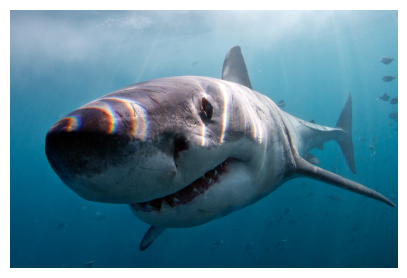

In [ ]:
show_image(im)

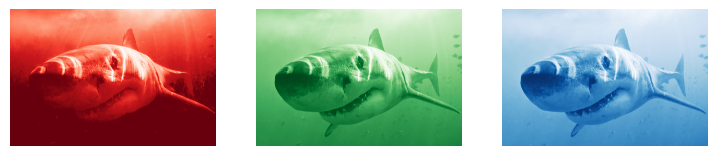

In [ ]:
_, axes = subplots(1,3)
for shark, ax, colour in zip(im, axes, ("Reds", "Greens", "Blues")):
    show_image(255-shark, ax=ax, cmap=colour)

Since we're now looking at colours, we need to have a filter that is `channels_in` \* 3 \* 3 as we need a filter for each channel instead of sharing a single filter, we can then stack those three filters ontop of eachother and sum them for a final result.

There is then a `channels_out` filter which is the stack of our convolutions, it should be of size `channels_in` \* `kernel_size` \* `kernel_size` that we represent in a single tensor of 4 dimensions, in pytorch the order is `channels_out` \* `channels_in` \* `kernel_size` \* `kernel_size`.

We may also want a bias for each filter which should be a vector of the size of `channels_out`.

Another note made in the book is that transforming the images between RGB or HSV etc are not valuable exercises unless you lose information in that transformation in which its a destructive and bad activity.

I'd love to come back and look at the [Zeiler and Fergus paper](https://arxiv.org/abs/1311.2901) which explains what each layer of a neural net 'sees' and creates these quite beautiful pictures of each layer picking up certain features.

### Improving Training Stability

Lets now look at beasting MNIST's full dataset instead of the sample of 3s and 7s.

In [ ]:
path = untar_data(URLs.MNIST)
Path.BASE_PATH = path
path.ls()

(#2) [Path('testing'),Path('training')]

In [ ]:
def get_dataloaders(bs=16):
    return DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter("training","testing"),
    get_y=parent_label,
    batch_tfms=Normalize()).dataloaders(path,bs=bs)

dls = get_dataloaders()

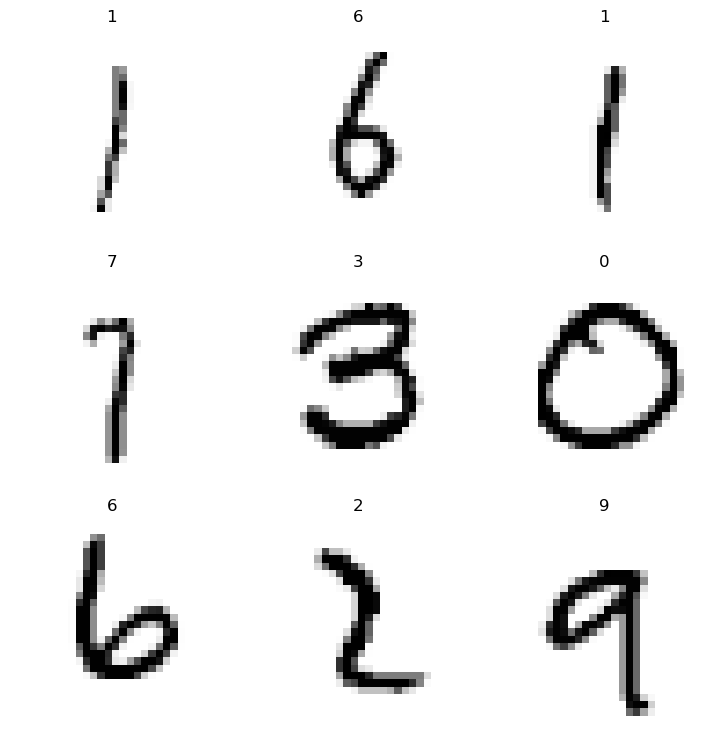

In [ ]:
dls.show_batch()

#### A Simple Baseline

Lets use our old simple CNN model as a baseline, only with a tweak to have more activations since we have more numbers to predict, its likely we'll need to learn more filters to accomodate that as well. If we follow our previous examples, we double the number of activations each time we run a convolutional layer, however our first layer previously had four output filters, this meant 4 values were being calculated from 9 pixels at each location. If we double this to eight filters, our kernel will be using 9 pixels to calculate 8 numbers, which isn't really 'learning' much since its spitting out what gets put in, we need to force the net to learn and usually that comes from having less outputs than the number of inputs.

To fix this we can use a larger kernel in the first layer, 5x5 for example will cause 25 pixels being used for each kernel application, creating 8 filters from this means the net will have to learn something useful

In [ ]:
def big_filter_cnn():
    return sequential(
    conv(1,8,ks=5),
    conv(8,16),
    conv(16,32),
    conv(32,64),
    conv(64,10, act=False),
    Flatten(),)

We will in a moment look inside our models whilst they are training in order to learn how to improve them, we can use the `ActivationStats` callback which records the mean, std deviation, and histogram of activations in every layer

In [ ]:
from fastai.callback.hook import *

In [ ]:
def fit(epochs=1):
    learn = Learner(dls,
                   big_filter_cnn(),
                   loss_func=F.cross_entropy,
                   metrics=accuracy,
                   cbs=ActivationStats(with_hist=True))
    learn.fit(epochs,0.06)
    return learn

learn = fit()

c:\users\nick\documents\github\fastai\fastai\callback\core.py:69: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,valid_loss,accuracy,time
0,2.309638,2.327736,0.095800,08:43


`Activationstats` includes handy utilities for plotting progress during training, in particular the plot_layer_stats(idx) plots the mean, std deviation of the activations of layer number `idx`, along with the percentage of activations near zero, lets make the first layer

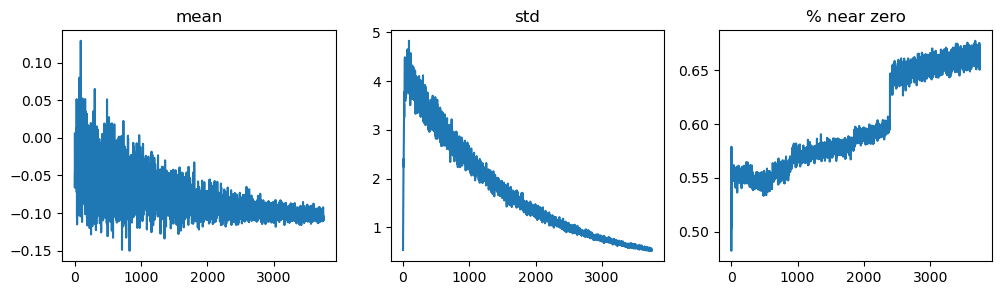

In [ ]:
learn.activation_stats.plot_layer_stats(0)

The book says our model should have consistent or at least smooth mean, and standard deviations of layer activations during training, activations near zero are problematic because we have computation doing nothing. When you have some zeros in one layer, they will generally carry over to the next layer and onwards, lets checkout the second last layer of our network

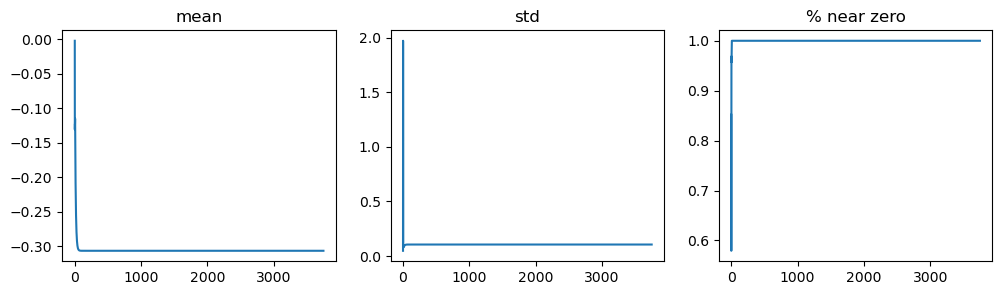

In [ ]:
learn.activation_stats.plot_layer_stats(-2)

The problem gets worse towards the end of the network, the instability and zero activations compound over layers, lets see if we can make training more 'stable'

### 1Cycle Training

We've currently always trained with a static learning rate, if we pick a bad value, we're toasted for the whole process, it also doesn't allow us to train with a lower learning rate near the end of training since we've 'learnt' a lot at that point and could easily skip over a minimum if the learning rate is established too high.

What if we could schedule our learning rate, starting low as to not diverge to quickly, then speeding up as we head in the right direction and then slowing down at the end to hit the best minimum we can after we've learnt important concepts. Leslie Smith continues to dunk on learning rates, the same person who figured out the learning rate finder with mini batches, also developed the learning rate scheduling strategy, see his paper [Super Convergence: Very Fast Training of Neural Networks using Large Learning Rates](https://arxiv.org/abs/1708.07120). In this paper there are two phases, a warmup where the learning rate grows to a maximum value and 'annealing' where the learning rate decreases back to a minimum value, Smith coined this process as '1cycle training'. According to fastbook, this allows us to train with a much higher maximum learning rate, giving two main benefits of training faster (The 'Super Convergence' bit) and avoiding overfitting by skipping over sharp local minimums, this means we end up in a smoother and more generalisable part of the loss function.

The second part of avoiding overfitting is based 'on the observation that a model that generalises well is one whose loss would not change very much if you changed the input by a small amount. If a model trains at a large learning rate for a sustained period and finds a good loss, it has found an area that generalises well since it is jumping from batch to batch without the loss changing (by definition generalising well)'. However if we 'start with this high LR, we're likely to diverge, so we start at a low LR, allow the optimiser to find smoother and smoother areas of our parameters by gradually going to higher and higher LRs'.

Once we've found this nice large loss surface, we then want to find the best minimum in that surface, so we then reduce the LR to find that sweet spot, how awesome!



In [ ]:
def cycle_fit(epochs=1, lr=0.06):
    learn = Learner(dls=dls,
                    model=big_filter_cnn(),
                    loss_func=F.cross_entropy,
                    metrics=accuracy,
                    cbs=ActivationStats(with_hist=True))
    learn.fit_one_cycle(epochs,lr)
    return learn
    
learn = cycle_fit()

c:\users\nick\documents\github\fastai\fastai\callback\core.py:69: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,valid_loss,accuracy,time
0,0.261028,0.312006,0.904700,03:36


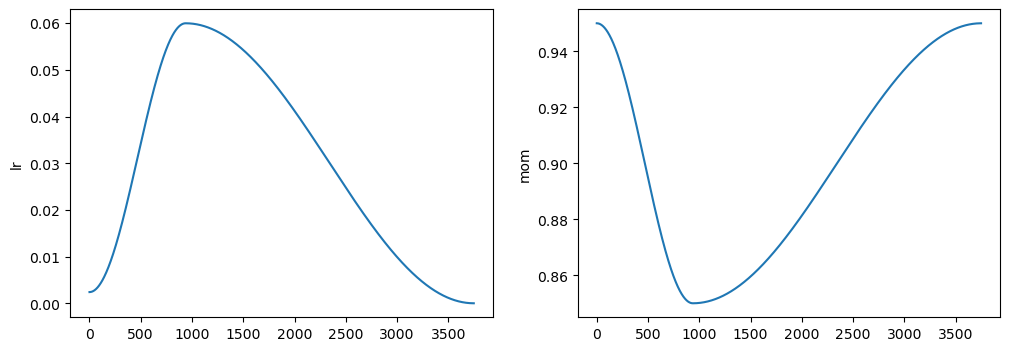

In [ ]:
learn.recorder.plot_sched()

fastai in particular combines the 1cycle learning rate with another strategy called ['cosine annealing'](https://paperswithcode.com/method/cosine-annealing) which follows the same strategy of annealing the learning rate back down but instead it drastically reduces the learning rate down to the minimum and then back up again, a sort of mini-restart but with warmed up weights etc. That papers-with-code link has a great example

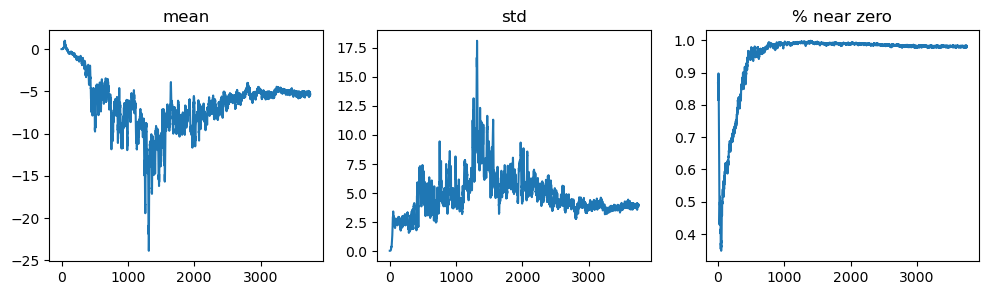

In [ ]:
learn.activation_stats.plot_layer_stats(-2)

Ok its not perfect but its still way better than before, we've still got a bajillion weights near zero however which is a massive concern, lets checkout the activation stats as a colour dimension.

For context, the [fast.ai forums has an excellent post explaining the logic behind this visualisation](https://forums.fast.ai/t/the-colorful-dimension/42908), the intuition being that we'd expect a normal distribution of activations (bear in mind we're going to look at the log of the activation histogram), however with how many '% near zero' activations we have, ours is going to look pretty janky.

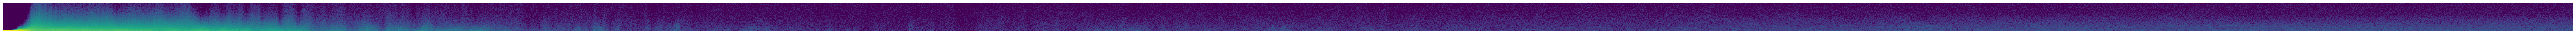

In [ ]:
learn.activation_stats.color_dim(-2, figsize=(100,30))

And there we have it, very bad training! Our model is full of close to 0 activations as you can see with the intensity of colour on the far left of the plot, whereas it dissipates to the blue/purple low values as we traverse to the right across the activation histogram. It also looks like the activations go up, and then collapse again a few times before spreading out more randomly.

### Batch Normalisation

To fix these near zero activations, we're going to introduce batch normalisation which should set the activations more uniformly at the beginning of which we can then try to maintain through training.

The [original paper](https://arxiv.org/abs/1502.03167) describes the problem we've re-created above and they write in the abstract: ~'Training NN's is complicated by the fact that the distribution of each layer's inputs change during training as the parameters of the previous layers change, this slows down training by requiring the lowering of LRs and careful parameter initialisation. We refer to this phenomenon as internal vocariate shift, and address the problem by normalising layer inputs.'

Their solution stated is: ~'Making normalisation a part of the model architecture and performing the normalisation for each training mini-batch, batch-norm allows us to use much higher learning rates and be less careful about initialisation'

The paper release created quite a buzz since it showed batch-norm could train a model 5x faster that was more accurate than the current SoTa.

Batch norm works by taking an average of the mean and standard deviation of the activations of a layer and using those to normalise the activations. This can cause problems because a network might want certain activations to be really high in order to make an accurate prediction, so they added two learnable parameters called *gamma* and *beta*. After normalising the activations to get some new activation vector **y**, a batchnorm layer returns *gamma* \* **y** + *beta*. This is why our activations can have any mean or variance, independent from the mean and std deviation of the results of the previous layer, those statistics are learned separately, making training easier on our model. The behaviour is different during training and validation, during training we use the mean and std deviation of the batch to normalise the data, whereas during validation we instead use a running mean of the statistics calculated during training.

Lets add in batch-norm

In [ ]:
def conv(ni, nf, ks=3, act=True):
    layers = [nn.Conv2d(ni,
                        nf,
                        stride=2,
                        kernel_size=
                        ks,
                        padding=ks//2)]
    if act: layers.append(nn.ReLU())
    layers.append(nn.BatchNorm2d(nf))
    return nn.Sequential(*layers)

In [ ]:
learn = fit()

c:\users\nick\documents\github\fastai\fastai\callback\core.py:69: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,valid_loss,accuracy,time
0,0.144128,0.078701,0.976700,03:01


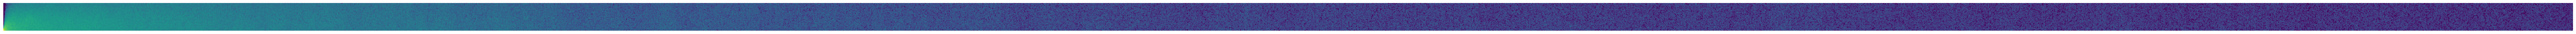

In [ ]:
learn.activation_stats.color_dim(-4, figsize=(100,30))

How awesome is that! Way more stable and we don't see that crashing we observed before. The book notes that `we tend to see these models generalise better than other models that don't contain this batch normalisation, although there doesn't seem to be any rigorous analysis as to why that is so, most researchers believe that batch-norm adds some extra randomness to the training process. Each mini-batch will be somewhat different in mean and std deviation than other mini batches, therefore the activations will be normalised with different values each time. In order for the model to make accurate predictions, it will have to learn to become robust to these variations. In general, adding randomness to the training process helps.`



In [ ]:
activation_stats